# Project 2 — Dijkstra’s Algorithm (Final)

Variants implemented and evaluated:
1. **Adjacency Matrix + Array-based Priority Queue**  
2. **Adjacency List + Binary Min-Heap**  

This version focuses the plots on two *explicit* levers:
- **How changing V affects runtime** (keeping density fixed)
- **How changing E affects runtime** (keeping V fixed and sweeping density)

> Assumption: All edge weights are non-negative (standard Dijkstra condition).

## 0. Setup & Utilities

In [1]:
import random
import math
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple

random.seed(42)

def gen_random_weight():
    return random.randint(1, 10)  # positive weights

def make_random_digraph(n: int, density: float) -> List[List[float]]:
    """Directed graph, adjacency matrix with math.inf for no-edge.
    density is the probability of edge i->j, i != j.
    """
    A = [[math.inf]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if random.random() < density:
                A[i][j] = gen_random_weight()
    return A

def matrix_to_adjlist(A: List[List[float]]) -> List[List[Tuple[int, float]]]:
    n = len(A)
    G = [[] for _ in range(n)]
    for u in range(n):
        row = A[u]
        for v, w in enumerate(row):
            if w != math.inf and u != v:
                G[u].append((v, w))
    return G

def count_edges_matrix(A: List[List[float]]) -> int:
    n = len(A)
    m = 0
    for i in range(n):
        row = A[i]
        for j in range(n):
            if i != j and row[j] != math.inf:
                m += 1
    return m

## 1. Dijkstra Implementations

In [ ]:
import numpy as np

def dijkstra_matrix_numpy(A, s):
    A = np.asarray(A, dtype=np.float64)           # O(V²) - space for matrix
    n = A.shape[0]
    dist = np.full(n, np.inf, dtype=np.float64)   # O(V)
    visited = np.zeros(n, dtype=bool)             # O(V)
    dist[s] = 0.0

    for _ in range(n):                            # O(V) iterations
        # O(V) - scanning all vertices for minimum
        u = np.argmin(np.where(~visited, dist, np.inf))
        if not np.isfinite(dist[u]):
            break

        # O(V) - scanning all possible neighbors
        mask = ~visited
        cand = dist[u] + A[u]                     
        dist[mask] = np.minimum(dist[mask], cand[mask])

        visited[u] = True

    return dist.tolist()

import heapq
def dijkstra_list_heap(G: List[List[Tuple[int, float]]], s: int) -> List[float]:
    n = len(G)                                    # O(1)
    dist = [math.inf]*n                           # O(V)
    dist[s] = 0.0
    pq = [(0.0, s)]                               # O(1)
    
    while pq:                                     # O(V) iterations (each vertex processed once)
        d, u = heapq.heappop(pq)                 # O(logV) per extraction
        if d != dist[u]:
            continue
        
        for v, w in G[u]:                        # O(deg(u)) per vertex
            nd = d + w                           # O(1)
            if nd < dist[v]:                     # O(1)
                dist[v] = nd                     # O(1)
                heapq.heappush(pq, (nd, v))      # O(logV) per edge relaxation
    
    return dist

## 2. Sanity Check

In [3]:
def sanity_check(trials=8, n=12, density=0.3):
    for t in range(trials):
        A = make_random_digraph(n, density)
        G = matrix_to_adjlist(A)
        s = random.randrange(n)
        d1 = dijkstra_matrix_numpy(A, s)
        d2 = dijkstra_list_heap(G, s)
        if any(abs(x - y) > 1e-9 for x, y in zip(d1, d2)):
            print('Mismatch on trial', t)
            return False
    print('All sanity checks passed.')
    return True

sanity_check()

All sanity checks passed.


True

## 3. Timing Harness

In [4]:
def time_once_matrix(A, s):
    t0 = time.perf_counter()
    dijkstra_matrix_numpy(A, s)
    return time.perf_counter() - t0

def time_once_list(G, s):
    t0 = time.perf_counter()
    dijkstra_list_heap(G, s)
    return time.perf_counter() - t0

def avg(xs):
    return sum(xs)/len(xs) if xs else float('nan')

## 4A. **Runtime vs V** (Fix density, vary V)

In [9]:
def sweep_V(ns, densities, trials=3):
    out = {}
    for label, p in densities.items():
        rows = []
        for n in ns:
            timesA, timesB = [], []
            for _ in range(trials):
                A = make_random_digraph(n, p)
                G = matrix_to_adjlist(A)
                s = random.randrange(n)
                timesA.append(time_once_matrix(A, s))
                timesB.append(time_once_list(G, s))
            rows.append((n, 'Matrix+Array', avg(timesA)))
            rows.append((n, 'List+Heap', avg(timesB)))
        out[label] = rows
    return out

ns_V = list(range(50, 501, 50))
dens_V = {
    'Sparse (p≈2/V)': None,
    'Medium (p=0.1)': 0.1,
    'Dense (p=0.5)': 0.5,
    'Very Dense (p=0.9)': 0.9
}

def sweep_V_with_dynamic_sparse(ns, trials=3):
    out = {}
    label = 'Sparse (p≈2/V)'
    rows = []
    for n in ns:
        p = min(1.0, 2/n)
        timesA, timesB = [], []
        for _ in range(trials):
            A = make_random_digraph(n, p)
            G = matrix_to_adjlist(A)
            s = random.randrange(n)
            timesA.append(time_once_matrix(A, s))
            timesB.append(time_once_list(G, s))
        rows.append((n, 'Matrix+Array', avg(timesA)))
        rows.append((n, 'List+Heap', avg(timesB)))
    out[label] = rows
    fixed = {k:v for k,v in dens_V.items() if v is not None}
    out.update(sweep_V(ns, fixed))
    return out

results_vs_V = sweep_V_with_dynamic_sparse(ns_V, trials=3)
results_vs_V

{'Sparse (p≈2/V)': [(50, 'Matrix+Array', 0.0003790666669374332),
  (50, 'List+Heap', 8.633333588174233e-06),
  (100, 'Matrix+Array', 0.0011133333337056683),
  (100, 'List+Heap', 4.493333290156443e-05),
  (150, 'Matrix+Array', 0.0025665000005877423),
  (150, 'List+Heap', 8.783333335789696e-05),
  (200, 'Matrix+Array', 0.002975166666753163),
  (200, 'List+Heap', 9.443333328817971e-05),
  (250, 'Matrix+Array', 0.004903166666432905),
  (250, 'List+Heap', 0.00012803333265765104),
  (300, 'Matrix+Array', 0.004842766667328154),
  (300, 'List+Heap', 0.0001333666665838488),
  (350, 'Matrix+Array', 0.0078116333327974035),
  (350, 'List+Heap', 0.00024236666710445812),
  (400, 'Matrix+Array', 0.0058488000001185965),
  (400, 'List+Heap', 9.643333275259162e-05),
  (450, 'Matrix+Array', 0.012367666667463103),
  (450, 'List+Heap', 0.0003522333336150041),
  (500, 'Matrix+Array', 0.009911733332652753),
  (500, 'List+Heap', 0.00021413333342934493)],
 'Medium (p=0.1)': [(50, 'Matrix+Array', 0.000476500000

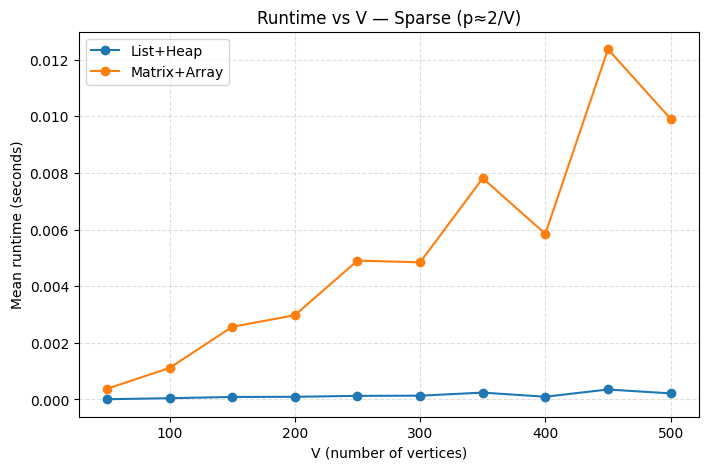

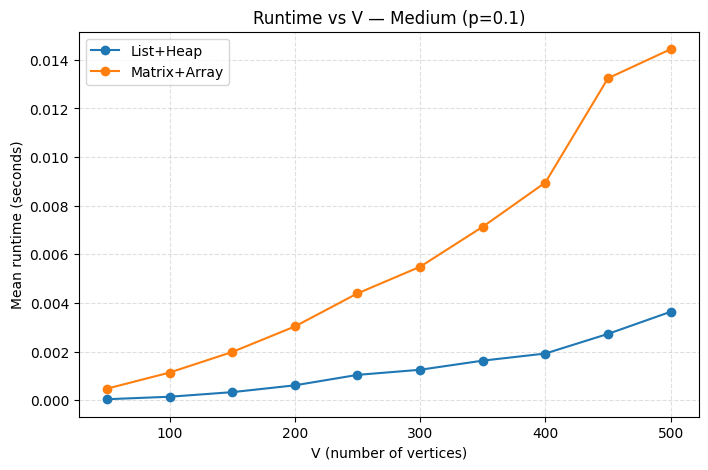

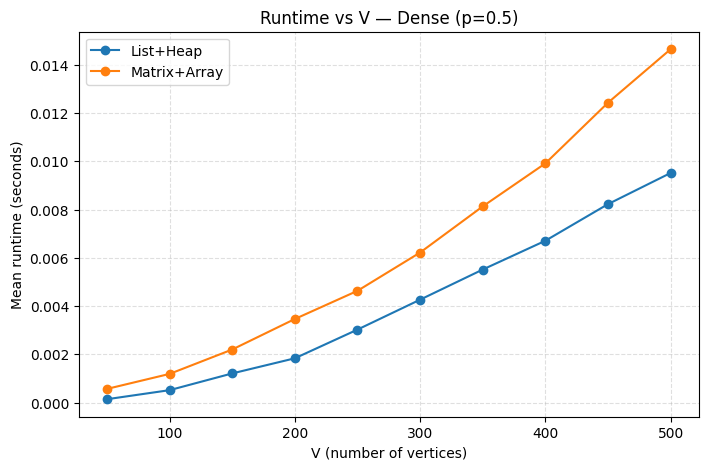

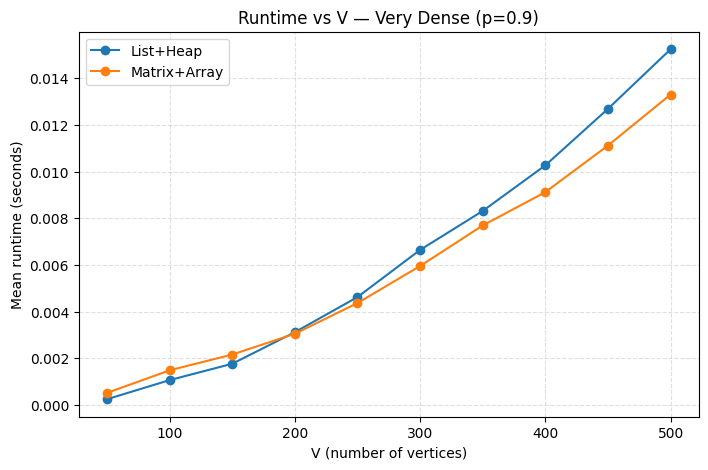

In [10]:
def plot_vs_V(rows, title):
    xs = sorted(set(v for v,_,_ in rows))
    algs = sorted(set(a for _,a,_ in rows))
    series = {a: [next(t for (vv, aa, t) in rows if vv==x and aa==a) for x in xs] for a in algs}
    plt.figure(figsize=(8,5))
    for a in algs:
        plt.plot(xs, series[a], marker='o', label=a)
    plt.title(title)
    plt.xlabel('V (number of vertices)')
    plt.ylabel('Mean runtime (seconds)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

for label, rows in results_vs_V.items():
    plot_vs_V(rows, f'Runtime vs V — {label}')

## 4B. **Runtime vs E** (Fix V, sweep density, measure E)

In [11]:
def sweep_E_at_fixed_V(n, ps, trials=3):
    rows = []
    for p in ps:
        timesA, timesB, Es = [], [], []
        for _ in range(trials):
            A = make_random_digraph(n, p)
            G = matrix_to_adjlist(A)
            s = random.randrange(n)
            Es.append(count_edges_matrix(A))
            timesA.append(time_once_matrix(A, s))
            timesB.append(time_once_list(G, s))
        E_mean = round(sum(Es)/len(Es))
        rows.append((E_mean, 'Matrix+Array', avg(timesA)))
        rows.append((E_mean, 'List+Heap', avg(timesB)))
    rows.sort(key=lambda x: x[0])
    return rows

V_fixed_list = list(range(100, 501, 100))
ps_E = [0.02, 0.05, 0.1, 0.2, 0.35, 0.5, 0.7, 0.9]
results_vs_E = {n: sweep_E_at_fixed_V(n, ps_E, trials=3) for n in V_fixed_list}
[(n, len(rows)) for n, rows in results_vs_E.items()]

[(100, 16), (200, 16), (300, 16), (400, 16), (500, 16)]

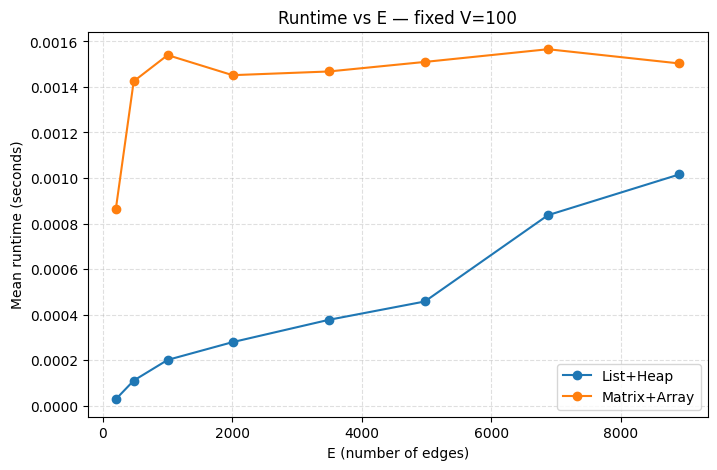

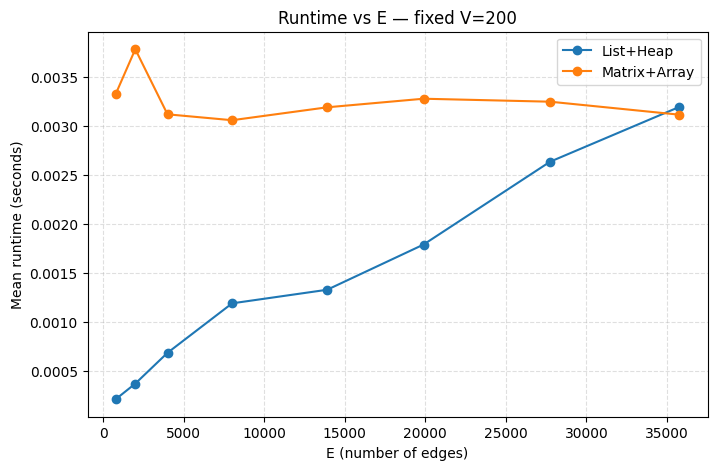

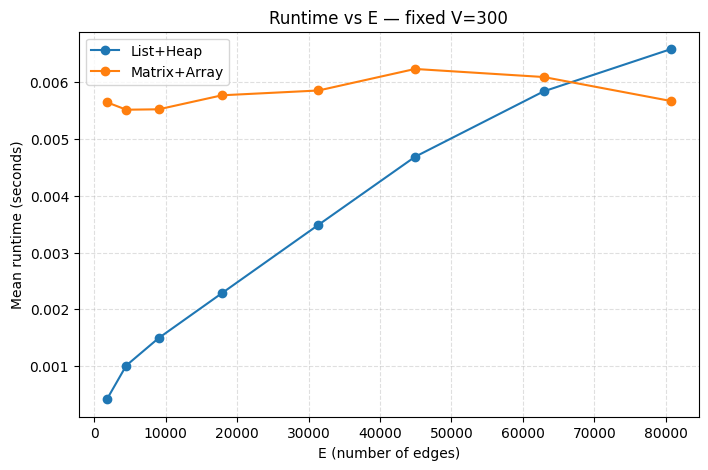

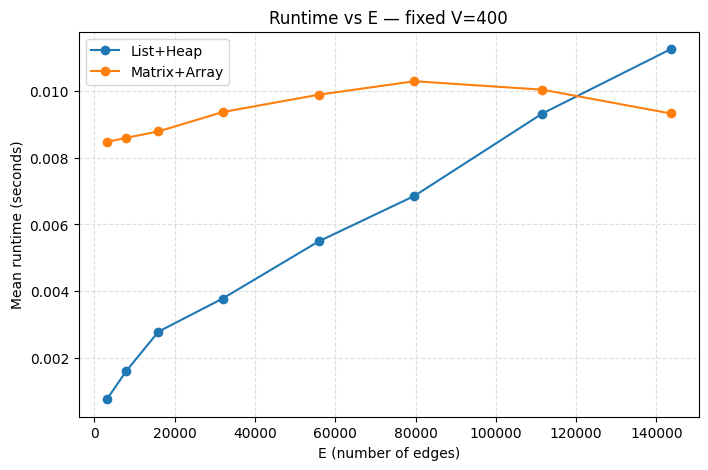

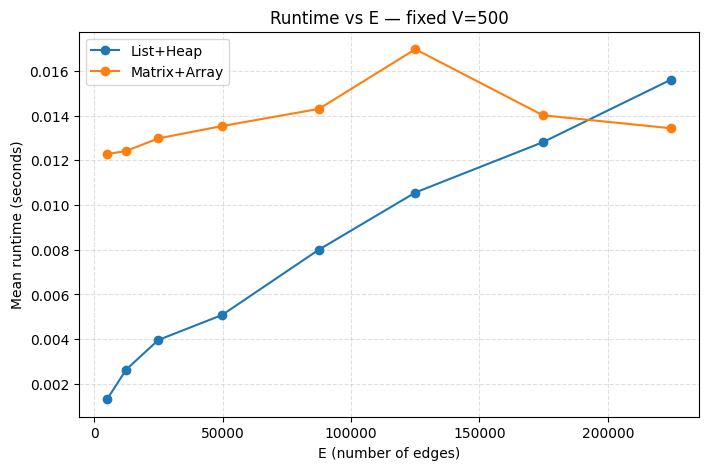

In [12]:
def plot_vs_E(rows, title):
    xs = sorted(set(e for e,_,_ in rows))
    algs = sorted(set(a for _,a,_ in rows))
    series = {a: [next(mt for (ee, aa, mt) in rows if ee==x and aa==a) for x in xs] for a in algs}
    plt.figure(figsize=(8,5))
    for a in algs:
        plt.plot(xs, series[a], marker='o', label=a)
    plt.title(title)
    plt.xlabel('E (number of edges)')
    plt.ylabel('Mean runtime (seconds)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

for n, rows in results_vs_E.items():
    plot_vs_E(rows, f'Runtime vs E — fixed V={n}')

## 5. Conclusion — Theory & Interpretation

### Complexity (theory)
- **Matrix + Array PQ:** \(O(V^2)\)
- **List + Binary Heap:** \(O((V+E)\log V)\)

### Expected trends
- **Runtime vs V (fixed p):** As V grows, E grows ~\(p\,V(V-1)\); the heap-based variant should generally remain below the matrix variant, except at very high densities.
- **Runtime vs E (fixed V):** Increasing E via density raises work roughly in line with \((V+E)\log V\) for the heap-based version, while the matrix version trends toward \(\Theta(V^2)\) independent of E.

### Your Explanation (fill after running)
- **Observation:** At low V and high density, and at high E, Matrix performs better than List.
- **Factors:** Matrix requires a different implementation to be more low level instead of using python loops in order to compete with List.